# Demo

Dataset source: https://www.kaggle.com/ranjeetshrivastav/fraud-detection-dataset

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from nodevectors import Node2Vec
import xgboost as xgb
from fucc.inductive_step import inductive_pooling
from fucc.metrics import plot_ap, get_optimal_f1_cutoff, get_confusion_matrix
from sklearn.metrics import average_precision_score
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
from fucc.pagerank import get_pagerank_suspicion_scores, inductive_step, splitDataFrameIntoSmaller, postprocessing_historical_edges
from fucc.utils import get_filename, export_suspicion_scores, import_suspicion_scores, multiprocessing
from tqdm import tqdm
from functools import partial
import datetime
import pickle

In [3]:
# Parameters
weighted = True
WORKERS = 12
lambdas = {'ST': 0.03, 'MT': 0.004, 'LT': 0.0001}
#lambdas = {'LT': 0.0001}
chunksize = 5000

In [4]:
output_path = ''

## Load Data

In [5]:
df = pd.read_json('/Users/raf/Dropbox/DOC/data/fraud_datasets/archive/transactions/transactions.txt',  lines=True, convert_dates=[4])

In [6]:
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4])

In [7]:
df = df.sort_values('transactionDateTime')
df.loc[:, 'TX_ID'] = range(df.shape[0])

In [8]:
df = df.rename(columns={"merchantName":"TERM_MIDUID", "customerId":"CARD_PAN_ID", "isFraud": "TX_FRAUD", "transactionDateTime":"TX_DATETIME"})

In [9]:
df_train = df.iloc[:320000]
df_val = df.iloc[320000:400000]
df_test = df.iloc[400000:500000]

In [10]:
personalization_nodes = list(df_train.index)

## Pagerank

In [11]:
%%time

dict_suspicion_scores = {}
dict_G = {}

for t, lambd in lambdas.items():
    suspicion_scores, G = get_pagerank_suspicion_scores(
                              df_train,
                              t=t,
                              lambd=lambd,
                              alpha=0.000085,
                              n_jobs=WORKERS,
                              personalization_nodes=personalization_nodes,
                              weighted=weighted)


    dict_suspicion_scores[t] = suspicion_scores
    dict_G[t] = G

INFO:root:Building network
INFO:root:Calculating edge weights for ST
INFO:root:Calculating some weights
INFO:root:ok, ST
INFO:root:Personalization
INFO:root:Building graph ST
INFO:root:Pagerank started


327266
5350


INFO:root:Pagerank finished
INFO:root:Building network
INFO:root:Calculating edge weights for MT
INFO:root:Calculating some weights
INFO:root:ok, MT
INFO:root:Personalization
INFO:root:Building graph MT
INFO:root:Pagerank started


327266
5350


INFO:root:Pagerank finished
INFO:root:Building network
INFO:root:Calculating edge weights for LT
INFO:root:Calculating some weights
INFO:root:ok, LT
INFO:root:Personalization
INFO:root:Building graph LT
INFO:root:Pagerank started


327266
5350


INFO:root:Pagerank finished


CPU times: user 1min 20s, sys: 3.32 s, total: 1min 24s
Wall time: 1min 25s


In [12]:
%%time
## Get suspicion scores for the validation part of the training data
data = df_val.set_index('TX_ID')
data = data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# We only need these columns from historical data
historical_data = df_train.set_index('TX_ID')
historical_data = historical_data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# Inductive val set processing

dict_results = {}
for t,lamb in lambdas.items():

    suspicion_scores, G = dict_suspicion_scores[t], dict_G[t]

    # split df in smaller chunks
    chunks = splitDataFrameIntoSmaller(data, chunkSize=2000)
    partial_inductive_step = partial(inductive_step, historical_edges=historical_data, suspicion_scores=suspicion_scores, G=G, t=t)

    result = multiprocessing(function=partial_inductive_step, chunks=chunks)
    #f#ilename = get_filename(filename_elements=[subset_name, t])
    
    dict_results[t] = result
    #result.to_csv(os.path.join(output_path, filename + '_output_val.csv'))

df_val_pagerank = df_val.copy()
for t, lamb in lambdas.items():
    #filename = get_filename(filename_elements=[subset_name, t])
    df_pagerank = dict_results[t]
    #df_pagerank = df_pagerank.set_index('TX_ID')
    df_pagerank = df_pagerank.filter(regex='SC_*')
    df_val_pagerank = df_val_pagerank.merge(df_pagerank, left_on='TX_ID', right_index=True) 

#filename = get_filename(filename_elements=[subset_name])
#df_val_pagerank.to_csv(os.path.join(output_path, subset_name + '_val_pagerank_inductive.csv'))

  0%|          | 0/41 [00:00<?, ?it/s]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 17%|█▋        | 7/41 [01:08<08:27, 14.92s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 27%|██▋       | 11/41 [02:05<05:31, 11.03s/it]INFO:root:post processing started
INFO:root:post processing started
 37%|███▋      | 15/41 [02:13<02:46,  6.41s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 54%|█████▎    | 22/41 [03:22<01:43,  5.47s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing s

In [13]:
%%time
# We only need these columns from data
data = df_test.set_index('TX_ID')
data = data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# We only need these columns from historical data
historical_data = df_train.set_index('TX_ID')
historical_data = historical_data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# Inductive test set processing

dict_results = {}
for t,lamb in lambdas.items():

    suspicion_scores, G = dict_suspicion_scores[t], dict_G[t]


    # split df in smaller chunks
    chunks = splitDataFrameIntoSmaller(data, chunkSize=2000)
    partial_inductive_step = partial(inductive_step, historical_edges=historical_data, suspicion_scores=suspicion_scores, G=G, t=t)

    result = multiprocessing(function=partial_inductive_step, chunks=chunks)
    dict_results[t] = result


df_test_pagerank = df_test.copy()
for t, lamb in lambdas.items():
    
    df_pagerank =  dict_results[t] 
    df_pagerank = df_pagerank.filter(regex='SC_*')
    df_test_pagerank = df_test_pagerank.merge(df_pagerank, left_on='TX_ID', right_index=True)


In [14]:
%%time
# We only need these columns from data
data = df_test.set_index('TX_ID')
data = data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# We only need these columns from historical data
historical_data = df_train.set_index('TX_ID')
historical_data = historical_data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]


# transductive train set processing
dict_results = {}
for t, lamb in lambdas.items():
    print(t)
    suspicion_scores, G = dict_suspicion_scores[t], dict_G[t]


    #Split historical dataset into smaller chunks
    chunks = splitDataFrameIntoSmaller(historical_data, chunkSize=5000)
    partial_postprocessing_historical_edges = partial(postprocessing_historical_edges, suspicion_scores=suspicion_scores, t=t)
    #partial_inductive_step = partial(inductive_step, historical_edges=historical_data, suspicion_scores=suspicion_scores, G=G, t=t)
    
    result = multiprocessing(function=partial_postprocessing_historical_edges, chunks=chunks)
    dict_results[t] = result

df_train_pagerank = df_train.copy()
# Load and join ST, MT, LT data for df_train and df_train
for t, lamb in lambdas.items():
    df_pagerank = dict_results[t]
    df_pagerank = df_pagerank.filter(regex='SC_*')
    df_train_pagerank = df_train_pagerank.merge(df_pagerank, left_on='TX_ID', right_index=True)

## XGBoost Classifier

In [15]:
df_train = df_train_pagerank
df_val = df_val_pagerank
df_test = df_test_pagerank

In [16]:
pagerank_features = list(df_train.filter(regex='SC').columns)

In [17]:
X_train = df_train[pagerank_features]
X_val = df_val[pagerank_features]
y_train = df_train.TX_FRAUD
y_val = df_val.TX_FRAUD

X_test = df_test[pagerank_features]
y_test = df_test.TX_FRAUD

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [18]:
xgb_params = {
    'eval_metric': ['auc','aucpr', 'logloss'],
    'objective':'binary:logistic',
    'n_estimators': 300,
    'n_jobs':8,
    'learning_rate':0.1,
    'seed':42,
    'colsample_bytree':0.6,
    'colsample_bylevel':0.9,
    'subsample':0.9
}

In [19]:
model = xgb.train(xgb_params, dtrain, num_boost_round=xgb_params['n_estimators'], evals=[(dval, 'val'), (dtrain, 'train')], early_stopping_rounds=int(xgb_params['n_estimators']/2))

In [27]:
y_pred_proba = model.predict(dtest)

## Evaluation

In [28]:
ap = average_precision_score(y_test, y_pred_proba)
print("Average Precision: ", np.round(ap,2))

Average Precision:  0.06


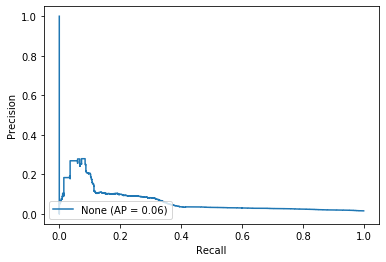

In [29]:
fig = plot_ap(y_test, y_pred_proba)

In [30]:
optimal_threshold, optimal_f1_score = get_optimal_f1_cutoff(y_test, y_pred_proba)
print("F1 Score: ", np.round(optimal_f1_score, 4))

F1 Score:  0.0706


In [31]:
cm = get_confusion_matrix(y_test, y_pred_proba, optimal_threshold)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[83475 14980]
 [  940   605]]


In [32]:
from sklearn.metrics import roc_auc_score

In [33]:
roc_auc_score(y_test, y_pred_proba)

0.7178016865425187